# Bitcoin price forecast

### ATENTION: This notebook has an error applying the scaler. The scaler should be fitted to the training data and then applied to all the data. This is not done in this notebook.

In [44]:
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [45]:
# dataset @ https://finance.yahoo.com/quote/BTC-USD/history/
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727
1,2019-01-19,3652.377930,3758.533447,3652.377930,3728.568359,3728.568359,5955691380
2,2019-01-20,3725.446045,3743.387939,3583.019531,3601.013672,3601.013672,5582489560
3,2019-01-21,3600.372803,3608.840820,3558.537109,3576.032471,3576.032471,5004347059
4,2019-01-22,3575.081299,3620.746582,3539.721436,3604.577148,3604.577148,5313623556


In [46]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,2019-01-18,3657.839355
1,2019-01-19,3728.568359
2,2019-01-20,3601.013672
3,2019-01-21,3576.032471
4,2019-01-22,3604.577148


In [47]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [48]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date'].head()

0   2019-01-18
1   2019-01-19
2   2019-01-20
3   2019-01-21
4   2019-01-22
Name: Date, dtype: datetime64[ns]

In [49]:
df.index = df.pop('Date')
df.head()

,Close
Date,
2019-01-18,3657.839355
2019-01-19,3728.568359
2019-01-20,3601.013672
2019-01-21,3576.032471
2019-01-22,3604.577148


In [50]:
period_in_days = 10
df['Change'] = (df['Close'].shift(-period_in_days) - df['Close']) / df['Close']
df.drop(df.index[-period_in_days:], inplace=True)
df

,Close,Change
Date,,
2019-01-18,3657.839355,-0.051229
2019-01-19,3728.568359,-0.075217
2019-01-20,3601.013672,-0.031889
2019-01-21,3576.032471,-0.033065
2019-01-22,3604.577148,-0.032357
...,...,...
2023-12-04,41980.097656,0.024866
2023-12-05,44080.648438,-0.048794
2023-12-06,43746.445313,-0.034433


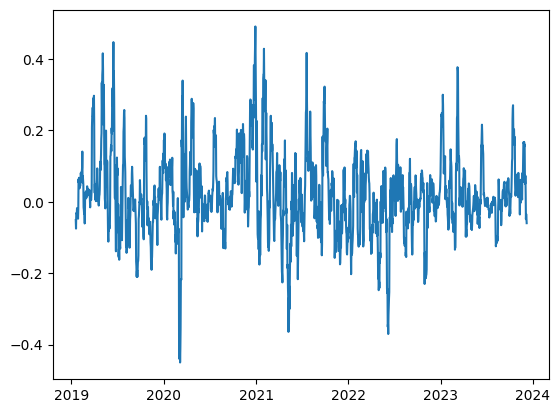

In [51]:
plt.plot(df.index, df['Change'])

In [52]:
change_percentage = 4
df['Change_bin'] = (df['Change'] >= change_percentage/100).astype(int)
df = df[['Close', 'Change_bin']]
df.head()

,Close,Change_bin
Date,,
2019-01-18,3657.839355,0
2019-01-19,3728.568359,0
2019-01-20,3601.013672,0
2019-01-21,3576.032471,0
2019-01-22,3604.577148,0


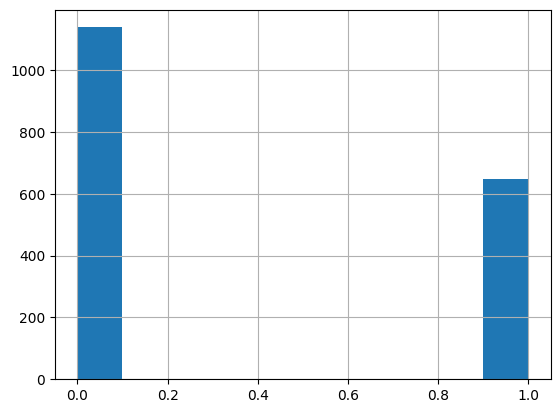

In [53]:
df['Change_bin'].hist()
plt.show()

In [54]:
scaler = MinMaxScaler(feature_range=(0, 1))
close_scaled = scaler.fit_transform(df['Close'].values.reshape(-1,1))
df['Close'] = close_scaled
df.head()

<ipython-input-54-51c6a9efea77>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = close_scaled


,Close,Change_bin
Date,,
2019-01-18,0.004026,0
2019-01-19,0.005129,0
2019-01-20,0.003141,0
2019-01-21,0.002752,0
2019-01-22,0.003196,0


In [55]:
import numpy as np

# n = number of features
def df_to_windowed_df(dataframe, n=3):
  column_features = dataframe.columns[:-1]
  target = dataframe.loc[:,df.columns[-1]].to_numpy()
  dates = dataframe.index[n-1:].to_numpy()
  Y = target[n-1:]
  feat_amount = len(df.columns) - 1
  input_columns = []
  for i in range(1, feat_amount + 1):
    input_columns.append(dataframe.loc[:,dataframe.columns[-1 * i - 1]].to_numpy())

  X = []
  # X[j] correspond to the j-th feature
  for i in range(feat_amount):
    X.append([])
  for i in range(n):
    for j in range(feat_amount):
      if i == n - 1:
        X[j].append(input_columns[j][i:])
      else:
        X[j].append(input_columns[j][i:i - n + 1])

  ret_df = pd.DataFrame()
  ret_df['Date'] = dates

  for i in range(0, n):
    for j in range(feat_amount):
      ret_df[f'Target-{column_features[j]}-{n-i}'] = X[j][i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, n=10)
windowed_df.head()

,Date,Target-Close-10,Target-Close-9,Target-Close-8,Target-Close-7,Target-Close-6,Target-Close-5,Target-Close-4,Target-Close-3,Target-Close-2,Target-Close-1,Target
0,2019-01-27,0.004026,0.005129,0.003141,0.002752,0.003196,0.002893,0.003139,0.003121,0.003163,0.002875,0
1,2019-01-28,0.005129,0.003141,0.002752,0.003196,0.002893,0.003139,0.003121,0.003163,0.002875,0.001106,0
2,2019-01-29,0.003141,0.002752,0.003196,0.002893,0.003139,0.003121,0.003163,0.002875,0.001106,0.000758,1
3,2019-01-30,0.002752,0.003196,0.002893,0.003139,0.003121,0.003163,0.002875,0.001106,0.000758,0.001351,1
4,2019-01-31,0.003196,0.002893,0.003139,0.003121,0.003163,0.002875,0.001106,0.000758,0.001351,0.000909,1


In [56]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((1777,), (1777, 10, 1), (1777,))

In [57]:
train_percentage = 0.7
val_percentage = 0.1
test_percentage = 0.2

assert train_percentage + val_percentage + test_percentage == 1

lim_train = int(len(dates) * train_percentage)
lim_val = int(len(dates) * val_percentage)

dates_train, X_train, y_train = dates[:lim_train], X[:lim_train], y[:lim_train]
dates_val, X_val, y_val = dates[lim_train: lim_train + lim_val], X[lim_train: lim_train + lim_val], y[lim_train: lim_train + lim_val]
dates_test, X_test, y_test = dates[ lim_train + lim_val:], X[ lim_train + lim_val:], y[ lim_train + lim_val:]

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras import layers, regularizers
from sklearn.utils.class_weight import compute_class_weight

# Suponiendo que y_train es tu conjunto de etiquetas de entrenamiento
# Calcula los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weight_dict)

# Modificaciones en la arquitectura del modelo
model = Sequential()
model.add(layers.LSTM(32, input_shape=(10, 1), activation='tanh'))  # Uso de tanh y sigmoid
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

# Ajustes en la tasa de aprendizaje y el decaimiento
lr_schedule = InverseTimeDecay(0.005,
                               decay_steps=1000,
                               decay_rate=0.95,
                               staircase=True)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule),
              metrics=['accuracy'])

# Entrenamiento del modelo
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, class_weight=class_weight_dict)

{0: 0.8253652058432935, 1: 1.2683673469387755}
Epoch 1/30
39/39 [==============================] - 2s 19ms/step - loss: 0.7818 - accuracy: 0.5672 - val_loss: 0.7216 - val_accuracy: 0.2486
Epoch 2/30
39/39 [==============================] - 0s 4ms/step - loss: 0.7012 - accuracy: 0.5109 - val_loss: 0.7159 - val_accuracy: 0.2486
Epoch 3/30
39/39 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5028 - val_loss: 0.7109 - val_accuracy: 0.2486
Epoch 4/30
39/39 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.4956 - val_loss: 0.7161 - val_accuracy: 0.2486
Epoch 5/30
39/39 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.4867 - val_loss: 0.7144 - val_accuracy: 0.2486
Epoch 6/30
39/39 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.4924 - val_loss: 0.7094 - val_accuracy: 0.2486
Epoch 7/30
39/39 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.4924 - val_loss: 0.

39/39 [==============================] - 0s 1ms/step
[[195 558]
 [ 77 413]]


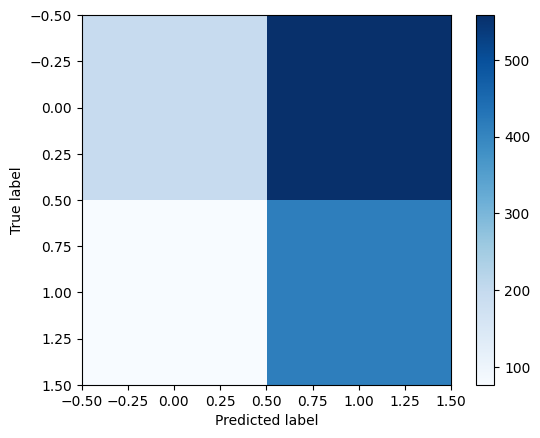

In [59]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_train)

# Threshold para convertir la salida del modelo en una predicción binaria
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train, y_pred_binary)

# Imprimir la matriz de confusión
print(cm)

# Graficar la matriz de confusión
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [60]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_train)
y_pred = np.round(y_pred)

# confusion matrix
import sklearn.metrics as skm

cm = confusion_matrix(y_train, y_pred)
cr = classification_report(y_train, y_pred)

print("Matriz de Confusión:")
print(cm)
print("\nClassification Report:")
print(cr)

39/39 [==============================] - 0s 1ms/step
Matriz de Confusión:
[[195 558]
 [ 77 413]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.26      0.38       753
         1.0       0.43      0.84      0.57       490

    accuracy                           0.49      1243
   macro avg       0.57      0.55      0.47      1243
weighted avg       0.60      0.49      0.45      1243



In [61]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

# confusion matrix
import sklearn.metrics as skm

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Matriz de Confusión:")
print(cm)
print("\nClassification Report:")
print(cr)

12/12 [==============================] - 0s 1ms/step
Matriz de Confusión:
[[  0 243]
 [  0 114]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       243
         1.0       0.32      1.00      0.48       114

    accuracy                           0.32       357
   macro avg       0.16      0.50      0.24       357
weighted avg       0.10      0.32      0.15       357



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
